# Face Generation

In this project, we'll define and train a DCGAN on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, we'll be able to visualize the results of our trained Generator to see how it performs; our generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

We'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train our adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) we've been working with, and so, we should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that we utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, *some* of the pre-processing is already done. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If we are working locally, we can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that we'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, we should be left with a directory of data `processed_celeba_small/`

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

In [3]:
# can comment out after executing
# !unzip processed-celeba-small.zip
# !rm -rf __MACOSX

In [4]:
# Import packages
import numpy as np, pickle as pkl
import problem_unittests as tests
import matplotlib.pyplot as plt
import torch

from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

%matplotlib inline

# Set seed
seed = 2020
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu: print('No GPU found. Please use a GPU to train neural network.')
else: print('Training on GPU!')

data_dir = 'processed_celeba_small/'

Training on GPU!


## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, *some* of the pre-processing for us. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that we'll need to **transform** this data and create a **DataLoader**.

#### `get_dataloader` function:

* Our images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Our function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that we use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
def get_dataloader(batch_size, image_size, data_dir = 'processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform = transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

## Create a DataLoader

#### Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* We can decide on any reasonable `batch_size` parameter
* Our `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Call our function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, We can view some images! We should see square images of somewhat-centered faces.

Note: We'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

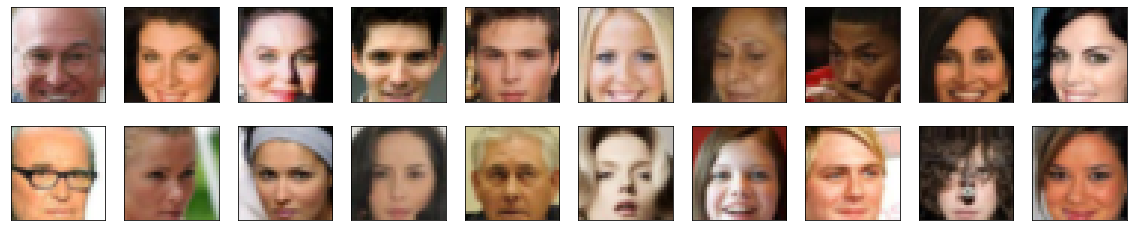

In [7]:
# Helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize = (20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx + 1, xticks = [], yticks = [])
    imshow(images[idx])

#### Pre-process our image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# Current range
img = images[0]

print('Current Range -- Min: ', img.min())
print('Current Range -- Max: ', img.max())

Current Range -- Min:  tensor(0.1059)
Current Range -- Max:  tensor(0.9725)


In [9]:
# Scale function
def scale(x, feature_range = (-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# Check scaled range, should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Scaled Range -- Min: ', scaled_img.min())
print('Scaled Range -- Max: ', scaled_img.max())

Scaled Range -- Min:  tensor(-0.7882)
Scaled Range -- Max:  tensor(0.9451)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Our first task will be to define the discriminator. This is a convolutional classifier like we've built before, only without any maxpooling layers. To deal with this complex data, it's suggested we use a deep network with **normalization**. We can also create any helper functions that may be useful.

#### Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
# Helper conv function
def conv(in_channels, out_channels, kernel_size, stride = 2, 
         padding = 1, batch_norm = True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, 
                           stride, padding, bias = False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, drop_prob = 0.2):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(in_channels = 3, out_channels = conv_dim, 
                          kernel_size = 4, batch_norm = False)
        self.conv2 = conv(in_channels = conv_dim, out_channels = conv_dim * 2, 
                          kernel_size = 4, batch_norm = True)
        self.conv3 = conv(in_channels = conv_dim * 2, out_channels = conv_dim * 4,
                          kernel_size = 4, batch_norm = True)
        self.conv4 = conv(in_channels = conv_dim * 4, out_channels = conv_dim * 8,
                          kernel_size = 4, batch_norm = True)
        self.fc = nn.Linear(conv_dim * 4 * 4 * 2, 1)
#         self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(-1, self.conv_dim * 4 * 4 * 2)
#         x = self.dropout(x)
        x = self.fc(x)
        return x

tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# Helper deconv function
def deconv(in_channels, out_channels, kernel_size, 
           stride = 2, padding = 1, batch_norm = True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, 
                                              bias = False)
    layers.append(transpose_conv_layer) 
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim, drop_prob = 0.2):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 2)
        self.t_conv1 = deconv(in_channels = conv_dim * 8, 
                              out_channels = conv_dim * 4, 
                              kernel_size = 4, batch_norm = True)
        self.t_conv2 = deconv(in_channels = conv_dim * 4, 
                              out_channels = conv_dim * 2, 
                              kernel_size = 4, batch_norm = True)
        self.t_conv3 = deconv(in_channels = conv_dim * 2, 
                              out_channels = conv_dim, 
                              kernel_size = 4, batch_norm = False)
        self.t_conv4 = deconv(in_channels = conv_dim, 
                              out_channels = 3, 
                              kernel_size = 4, batch_norm = False)
#         self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
#         x = self.dropout(x)
        x = x.view(-1, self.conv_dim * 8, 2, 2)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.tanh(self.t_conv4(x))
        return x

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of our networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, our next task will be to define a weight initialization function that does just this!

We can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help us complete this function.

#### Weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    std_dev = 0.02
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, std_dev)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, std_dev)
            nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define our models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure we've passed in the correct input arguments.

In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    """Define discriminator and generator; initialize model weights
    """
    D = Discriminator(d_conv_dim)
    G = Generator(z_size = z_size, conv_dim = g_conv_dim)
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    print('--'*15, 'Discriminator Model', '--'*15)
    print(D)
    print()
    print('--'*15, 'Generator Model', '--'*15)
    print(G)
    return D, G

#### Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

------------------------------ Discriminator Model ------------------------------
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

------------------------------ Generator Model ------------------------------
Generator(
  (fc): Linear(in_featur

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Real and Fake loss functions

**We may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth = False):
    batch_size = D_out.size(0)
    if smooth: labels = torch.ones(batch_size)*0.9
    else: labels = torch.ones(batch_size)   
    if train_on_gpu: labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu: labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for our Discriminator (D) and Generator (G)

Define optimizers for our models with appropriate hyperparameters.

In [19]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses.

* We should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

#### Saving Samples

#### Complete the training function

Keep in mind that, if we've moved our models to GPU, we'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every = 50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size = (sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu: fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            d_optimizer.zero_grad()
            if train_on_gpu: real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu: z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu: z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()            

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.\
                      format(epoch + 1, n_epochs, d_loss.item(), g_loss.item()))
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

Set our number of training epochs and train our GAN!

In [21]:
# set number of epochs 
n_epochs = 20

# call training function
losses = train(D, G, n_epochs = n_epochs)

Epoch [    1/   20] | d_loss: 1.4785 | g_loss: 1.1620
Epoch [    1/   20] | d_loss: 0.0590 | g_loss: 5.2394
Epoch [    1/   20] | d_loss: 0.0230 | g_loss: 6.0368
Epoch [    1/   20] | d_loss: 0.0119 | g_loss: 5.8092
Epoch [    1/   20] | d_loss: 0.1618 | g_loss: 5.0878
Epoch [    1/   20] | d_loss: 1.0688 | g_loss: 4.8111
Epoch [    1/   20] | d_loss: 0.2435 | g_loss: 3.9062
Epoch [    1/   20] | d_loss: 0.2904 | g_loss: 3.5485
Epoch [    1/   20] | d_loss: 0.3671 | g_loss: 3.9542
Epoch [    1/   20] | d_loss: 0.6565 | g_loss: 2.3758
Epoch [    1/   20] | d_loss: 0.6790 | g_loss: 4.2206
Epoch [    1/   20] | d_loss: 0.5844 | g_loss: 2.4637
Epoch [    1/   20] | d_loss: 0.4777 | g_loss: 3.3769
Epoch [    1/   20] | d_loss: 0.7877 | g_loss: 2.3918
Epoch [    1/   20] | d_loss: 0.4105 | g_loss: 3.3261
Epoch [    2/   20] | d_loss: 0.5929 | g_loss: 2.4854
Epoch [    2/   20] | d_loss: 0.7697 | g_loss: 2.1015
Epoch [    2/   20] | d_loss: 0.6791 | g_loss: 2.7170
Epoch [    2/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.4452 | g_loss: 2.7129
Epoch [   11/   20] | d_loss: 0.4216 | g_loss: 2.5014
Epoch [   11/   20] | d_loss: 0.7160 | g_loss: 1.1915
Epoch [   11/   20] | d_loss: 0.8530 | g_loss: 4.3665
Epoch [   11/   20] | d_loss: 0.9631 | g_loss: 1.2645
Epoch [   11/   20] | d_loss: 0.5667 | g_loss: 2.7462
Epoch [   11/   20] | d_loss: 1.0920 | g_loss: 0.7833
Epoch [   11/   20] | d_loss: 0.4095 | g_loss: 3.1563
Epoch [   11/   20] | d_loss: 0.5651 | g_loss: 1.7464
Epoch [   11/   20] | d_loss: 0.5453 | g_loss: 2.3972
Epoch [   11/   20] | d_loss: 0.7794 | g_loss: 1.9796
Epoch [   11/   20] | d_loss: 0.8018 | g_loss: 2.9179
Epoch [   11/   20] | d_loss: 1.1854 | g_loss: 1.1933
Epoch [   12/   20] | d_loss: 0.4438 | g_loss: 0.9889
Epoch [   12/   20] | d_loss: 0.4474 | g_loss: 3.3871
Epoch [   12/   20] | d_loss: 0.5530 | g_loss: 3.1484
Epoch [   12/   20] | d_loss: 0.7449 | g_loss: 1.0909
Epoch [   12/   20] | d_loss: 0.5806 | g_loss: 1.5977
Epoch [   12/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

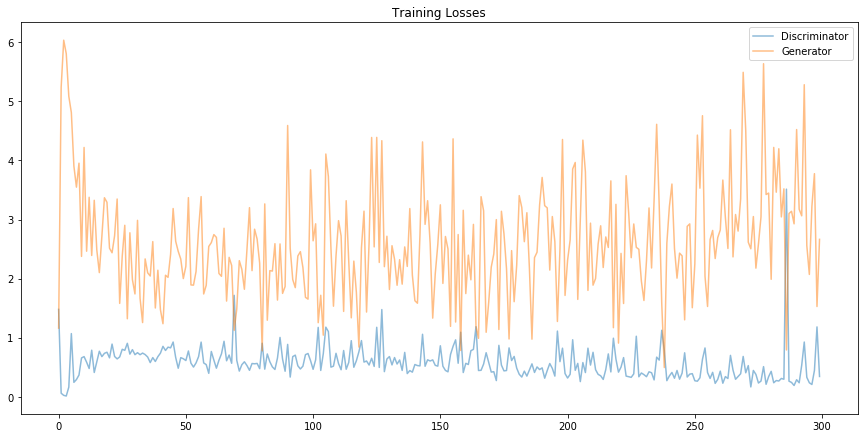

In [22]:
fig, ax = plt.subplots(figsize = (15, 7.2))
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator', alpha = 0.5)
plt.plot(losses.T[1], label = 'Generator', alpha = 0.5)
plt.title('Training Losses')
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of our trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize = (16, 4), nrows = 2, ncols = 8, 
                             sharey = True, sharex = True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32, 32, 3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

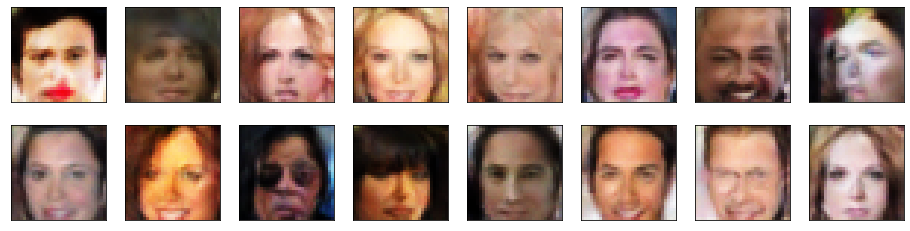

In [25]:
_ = view_samples(-1, samples)

### Question: What do we notice about our generated samples and how we might  improve this model?
When answering this question, let's consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect our final result

**Answer:**

* Started with, Attempt 1: `d_conv_dim, g_conv_dim = 32, 32` and a learning rate of 0.0002 with dropout before the final (linear) layer, model didn't converge well on generator loss.
* Attempt 2: with `d_conv_dim, g_conv_dim = 32, 32` and a learning rate of 0.002 without dropout layer before the linear layer, model started converging well and faces were also generated.
* As mentioned in the [paper](https://arxiv.org/pdf/1511.06434.pdf), the model architecture I used LeakyReLU activation in the discriminator and ReLU activation in generator for all layers except for output which is Tanh. Also the model had batchnorm layer in both discriminator and generator.
* As noted above, the dataset is biased with most of faces being of hollywood "celebrities" and faces were mostly white.
* Deeper convolutional GANs with larger image size and better resolution may also yield better results for the current problem
* Further, can also explore below option:
> *Remove fully connected hidden layers for deeper architectures - [source](https://arxiv.org/pdf/1511.06434.pdf)*